## CAPM
> This notebook demonstrates how to calculate the beta and expected return of a stock using the Capital Asset Pricing model. 

    Import the necessary libraries.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import quantfinanceHEC as qf
import seaborn as sns

    Fetch stock price data, compute returns, and format return dataframe.

In [88]:
start_date = "2002-01-01"
end_date = "2022-01-01"

# Get close price data for dg, xom and spy
dg = qf.data_fetching.f_fetch_stock_data(symbol="dg", start_date=start_date, end_date=end_date, interval="daily")["4. close"] 
xom = qf.data_fetching.f_fetch_stock_data(symbol="xom", start_date=start_date, end_date=end_date, interval="daily")["4. close"] 
spy = qf.data_fetching.f_fetch_stock_data(symbol="spy", start_date=start_date, end_date=end_date, interval="daily")["4. close"] 

prices = pd.concat([dg, xom, spy], axis = 1) # Merge dataframes
prices.columns = ["dg", "xom", "spy"] # Rename columns
prices = prices.iloc[::-1] # reverse order of index

In [89]:
returns = prices.pct_change(fill_method=None) # Compute returns
returns = returns.dropna() # Drop NAs (first row)

    Compute the  daily and annual expected return for all securities.

In [91]:
# Daily expected return
daily_exp_return_dg = returns["dg"].mean() # Expected return for dg
daily_exp_return_xom = returns["xom"].mean() # Expected return for xom
daily_exp_return_spy = returns["spy"].mean() # Expected return for spy

trading_days = 252 # Nb trading days / year

# Annualized expected return
ann_exp_return_dg = (1 + daily_exp_return_dg) ** trading_days - 1
ann_exp_return_xom = (1 + daily_exp_return_dg) ** trading_days - 1 
ann_exp_return_spy = (1 + daily_exp_return_spy) ** trading_days - 1


    Compute $DG's beta by OLS.

In [92]:
model_dg = qf.linear_regression.f_multivariate_linear_regression(data=returns, dependent_vars=["dg"], independent_vars=["spy"])
_, beta_dg = model_dg.params # Alpha and Beta of Dollar General
beta_dg

0.5660037513647538

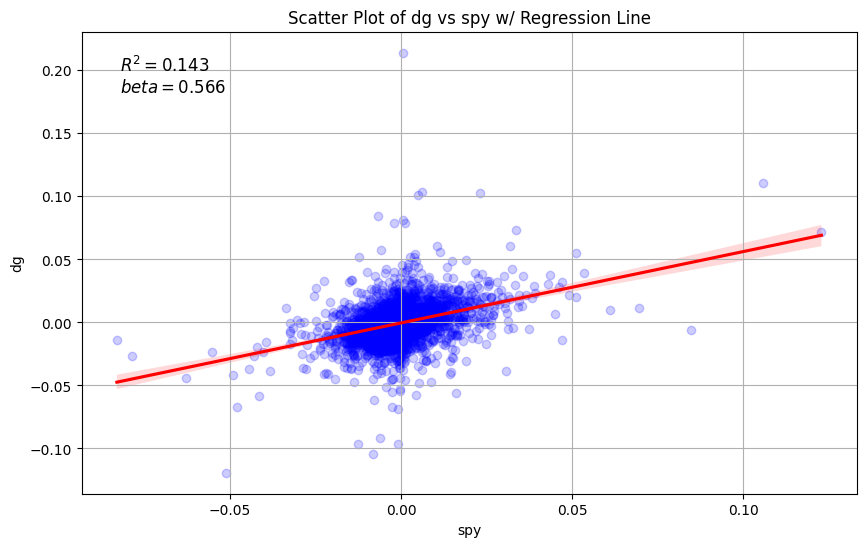

In [93]:
# Plotting the scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='spy', y='dg', data=returns, scatter_kws={'alpha':0.2, 'color':'blue'}, line_kws={'color':'red'})
plt.title('Scatter Plot of dg vs spy w/ Regression Line')
plt.xlabel('spy')
plt.ylabel('dg')
plt.grid(True)

# Adding the R^2 value to the plot
plt.text(0.05, 0.95, f'$R^2 = {model_dg.rsquared:.3f}$', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f'$beta = {beta_dg:.3f}$', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top')

plt.show()

    Similarly for $XOM.

In [94]:
model_xom = qf.linear_regression.f_multivariate_linear_regression(data=returns, dependent_vars=["xom"], independent_vars=["spy"])
_, beta_xom = model_xom.params # Alpha and Beta of Dollar General
beta_xom

0.9897938316918032

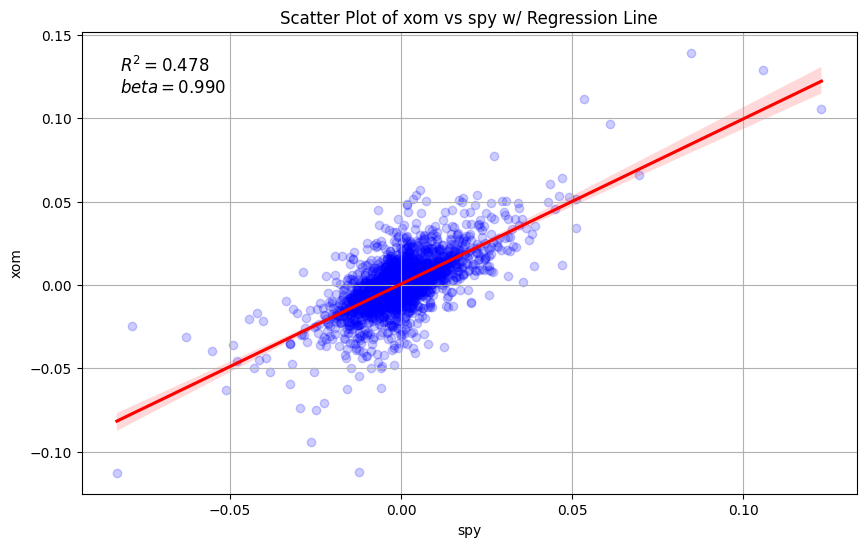

In [95]:
# Plotting the scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='spy', y='xom', data=returns, scatter_kws={'alpha':0.2, 'color':'blue'}, line_kws={'color':'red'})
plt.title('Scatter Plot of xom vs spy w/ Regression Line')
plt.xlabel('spy')
plt.ylabel('xom')
plt.grid(True)

# Adding the R^2 value to the plot
plt.text(0.05, 0.95, f'$R^2 = {model_xom.rsquared:.3f}$', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f'$beta = {beta_xom:.3f}$', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top')

plt.show()

    As expected, $XOMs beta is significantly higher than $DGs. We can also notice that the CAPM is a much better fit for $XOM than $DG.

In [96]:
covariance_matrix = qf.performance_analytics.f_calculate_covariance_matrix(returns)
var_dg = covariance_matrix.iloc[0, 0]
var_spy = covariance_matrix.iloc[1, 1]
covar_dg_spy = covariance_matrix.iloc[0, 1] # Also = covariance_matrix.iloc[1, 0]